<h1>Multilingual Sarcasm Detection in Social Media

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sarcasm/train .csv
/kaggle/input/sarcasm/test (1).csv


<h3>Loading the given Dataset</h3>

In [2]:
import pandas as pd

df = pd.read_csv("/kaggle/input/sarcasm/train .csv")  
df.dropna(inplace=True)
df['Label'] = df['Label'].map({'NO': 0, 'YES': 1})
df.head(10)

,ID,Tweet,Label
0,3037,ussase jayada dukhad congress ka nichi koti ki...,0
1,7640,takeout burrito shielded from cold as though i...,1
2,11848,sight of coworkers' stupid fucking faces endur...,1
3,4812,TIL that @RayuduAmbati is ek number ka chootiy...,0
4,13098,porch ceded to bats,1
5,5154,@AtiyaNoreen bara hi ajeeeb #sarcasm hai,0
6,1039,Bss do log hindi belt ki politics se hat jaye ...,0
7,7530,panicked donald trump jr. tries to cover up co...,1
8,7973,mike gravel can't believe his polling numbers ...,1
9,13830,"""Bhai, tumhari wisdom se sab overlooked detail...",1


<h3>Prepocessing the data

In [3]:
import re

def clean_text(text):
    text = text.lower() 
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  
    text = re.sub(r"[@#]", "", text)  
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  
    text = re.sub(r"\s+", " ", text).strip()  
    return text
    
df["Tweet"] = df["Tweet"].astype(str).apply(clean_text)
df.head(10)

,ID,Tweet,Label
0,3037,ussase jayada dukhad congress ka nichi koti ki...,0
1,7640,takeout burrito shielded from cold as though i...,1
2,11848,sight of coworkers stupid fucking faces endure...,1
3,4812,til that rayuduambati is ek number ka chootiya...,0
4,13098,porch ceded to bats,1
5,5154,atiyanoreen bara hi ajeeeb sarcasm hai,0
6,1039,bss do log hindi belt ki politics se hat jaye ...,0
7,7530,panicked donald trump jr tries to cover up con...,1
8,7973,mike gravel cant believe his polling numbers n...,1
9,13830,bhai tumhari wisdom se sab overlooked details ...,1


<h3>We tried various transformer but xlm-roberta-base was the best choice that can be applied to hinglish data</h3>

In [4]:
from transformers import AutoTokenizer

MODEL_NAME = "xlm-roberta-base" 
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_text(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=200, return_tensors="tf")

# Tokenizing the tweets
tokenized_data = tokenize_text(df["Tweet"].tolist())

from transformers import TFAutoModelForSequenceClassification
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)  # Binary classification

import tensorflow as tf
labels = tf.convert_to_tensor(df["Label"].values)

dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_data), labels))
dataset = dataset.shuffle(len(df)).batch(4)  

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFXLMRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFXLMRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<h3>Splitting into train and validation data

In [5]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(df["Tweet"], df["Label"], test_size=0.2, random_state=42)

# Tokenizing train and validation data
train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=200, return_tensors="tf")
val_encodings = tokenizer(list(val_texts), padding=True, truncation=True, max_length=200, return_tensors="tf")

# Converting labels to tensors
train_labels = tf.convert_to_tensor(list(train_labels))
val_labels = tf.convert_to_tensor(list(val_labels))

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).shuffle(len(train_texts)).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels)).batch(16)

In [6]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",  
    patience=4,  
    restore_best_weights=True,  
    verbose=1
)

EPOCHS = 20  
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=[early_stopping])

Epoch 1/20
492/492 [==============================] - 127s 177ms/step - loss: 0.1189 - accuracy: 0.9543 - val_loss: 0.0513 - val_accuracy: 0.9787
Epoch 2/20
492/492 [==============================] - 80s 163ms/step - loss: 0.0505 - accuracy: 0.9799 - val_loss: 0.0323 - val_accuracy: 0.9863
Epoch 3/20
492/492 [==============================] - 78s 160ms/step - loss: 0.0373 - accuracy: 0.9829 - val_loss: 0.0365 - val_accuracy: 0.9812
Epoch 4/20
492/492 [==============================] - 78s 159ms/step - loss: 0.0346 - accuracy: 0.9837 - val_loss: 0.0341 - val_accuracy: 0.9853
Epoch 5/20
492/492 [==============================] - 78s 159ms/step - loss: 0.0316 - accuracy: 0.9858 - val_loss: 0.0348 - val_accuracy: 0.9848
Epoch 6/20
492/492 [==============================] - 78s 159ms/step - loss: 0.0288 - accuracy: 0.9867 - val_loss: 0.0457 - val_accuracy: 0.9853
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 2.


In [8]:
loss, accuracy = model.evaluate(val_dataset)
print(f"Loss: {loss}, Accuracy: {accuracy}")

123/123 [==============================] - 6s 52ms/step - loss: 0.0323 - accuracy: 0.9863
Loss: 0.03234739974141121, Accuracy: 0.9862805008888245


<h2>Achieved a decent model with 98.62% accuracy</h2>

<h3>Saving the model for deployment purposes

In [17]:
model.save_pretrained("/kaggle/working/xlm_roberta_sarcasm_model")
tokenizer.save_pretrained("/kaggle/working/xlm_roberta_sarcasm_model")

('/kaggle/working/xlm_roberta_sarcasm_model/tokenizer_config.json',
 '/kaggle/working/xlm_roberta_sarcasm_model/special_tokens_map.json',
 '/kaggle/working/xlm_roberta_sarcasm_model/sentencepiece.bpe.model',
 '/kaggle/working/xlm_roberta_sarcasm_model/added_tokens.json',
 '/kaggle/working/xlm_roberta_sarcasm_model/tokenizer.json')

In [18]:
import shutil
shutil.make_archive("/kaggle/working/xlm_roberta_sarcasm_model", 'zip', "/kaggle/working/xlm_roberta_sarcasm_model")

'/kaggle/working/xlm_roberta_sarcasm_model.zip'

<h3>testing on given test data</h3>

In [9]:
test_df = pd.read_csv("/kaggle/input/sarcasm/test (1).csv")

In [10]:
test_df["Tweet"] = test_df["Tweet"].astype(str).apply(clean_text)

In [11]:
MODEL_NAME = "xlm-roberta-base"  
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

test_encodings = tokenizer(
    test_df["Tweet"].tolist(), 
    padding=True, 
    truncation=True, 
    max_length=200, 
    return_tensors="tf"
)

In [12]:
from sklearn.metrics import accuracy_score, classification_report
outputs = model(dict(test_encodings))  
logits = outputs.logits  
probabilities = tf.nn.softmax(logits).numpy()
predicted_labels = np.argmax(probabilities, axis=1)  # Get highest probability class
actual_labels = test_df["Label"].map({"NO": 0, "YES": 1}).values  # Convert labels to binary

In [13]:
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(actual_labels, predicted_labels))

Test Accuracy: 0.9862

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       706
           1       0.98      1.00      0.99      1403

    accuracy                           0.99      2109
   macro avg       0.99      0.98      0.98      2109
weighted avg       0.99      0.99      0.99      2109



<h3>We can now test the model for a particular tweet</h3>

In [29]:
def predict_sarcasm(tweet):
    inputs = tokenizer(tweet, return_tensors="tf", padding=True, truncation=True, max_length=128)
    outputs = model(**inputs)  
    logits = outputs['logits']  
    prediction = tf.nn.softmax(logits)
    return "Sarcastic" if tf.argmax(prediction, axis=1).numpy()[0] == 1 else "Not Sarcastic"

print(predict_sarcasm("Is player ko khelna bhi aata hai"))

Sarcastic


<h4>Evaluation with the help of various metrics and visuals

123/123 [==============================] - 9s 51ms/step


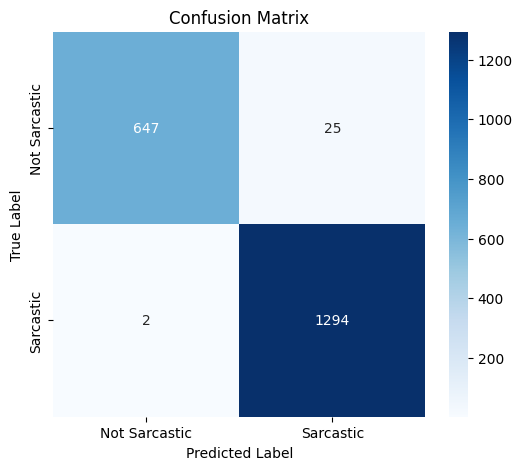

In [21]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_probs = model.predict(val_dataset)["logits"]  
y_pred = np.argmax(tf.nn.softmax(y_pred_probs), axis=1)  

y_true = val_labels.numpy()

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Sarcastic", "Sarcastic"], yticklabels=["Not Sarcastic", "Sarcastic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [22]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Not Sarcastic", "Sarcastic"]))

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       1.00      0.96      0.98       672
    Sarcastic       0.98      1.00      0.99      1296

     accuracy                           0.99      1968
    macro avg       0.99      0.98      0.98      1968
 weighted avg       0.99      0.99      0.99      1968



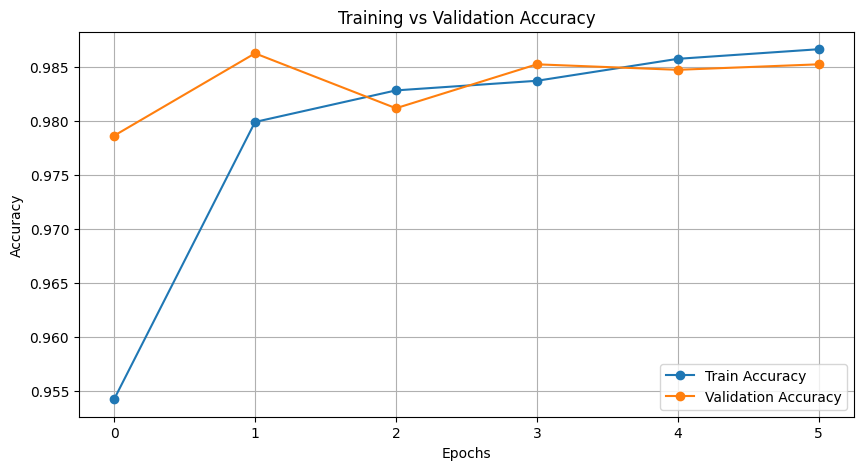

In [23]:
import matplotlib.pyplot as plt

history_dict = history.history

plt.figure(figsize=(10, 5))
plt.plot(history_dict['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

> <h3>It can be seen from above line plots that the model is trained decently and is neither underfitted nor overfitted

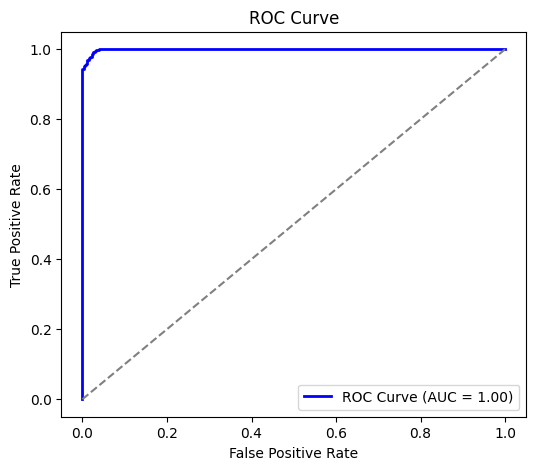

In [24]:
from sklearn.metrics import roc_curve, auc

y_probs = tf.nn.softmax(y_pred_probs).numpy()[:, 1]  # Probability of sarcasm
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guessing line y=x
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

<h4>Matthews Correlation Coefficient (MCC)</h4>
Measures the quality of predictions, even if classes are imbalanced.<br>
Values range from -1 (worst) to +1 (best).<br>
MCC = 0 means the model is making random predictions.<br>

In [25]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_true, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")


Matthews Correlation Coefficient: 0.9696


<h4>Cohen’s Kappa Score</h4>
Measures agreement between predicted and actual labels.<br>
1.0 → Perfect agreement, 0 → Random agreement.

In [26]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen’s Kappa Score: {kappa:.4f}")


Cohen’s Kappa Score: 0.9692


<h4>Log Loss (Cross-Entropy Loss)</h4>
Measures uncertainty in predictions.<br>
Lower values mean better confidence.

In [27]:
from sklearn.metrics import log_loss

logloss = log_loss(y_true, y_pred_probs)
print(f"Log Loss: {logloss:.4f}")


Log Loss: 0.1694
